<a href="https://colab.research.google.com/github/preethitp/SHAP/blob/main/shap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LABELS:**

1: Working at Computer (workingPC).

2: Standing Up, Walking and Going up/down stairs.

3: Standing (standing).

4: Walking (waking).

5: Going Up/Down Stairs (stairs).

6: Walking and Talking with Someone.

7: Talking while Standing (talking).

In [ ]:
!pip install shap

     |████████████████████████████████| 327kB 11.6MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463911 sha256=8a71324ef9863f737ba215d256cb93f6d427aaaba80762f11f1b66a6e79f5bb5
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap


In [ ]:
from glob import glob
import pandas as pd
import sklearn.ensemble
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np, pandas as pd, matplotlib.pyplot as plt, pydotplus
from sklearn import tree, metrics, model_selection, preprocessing
#from IPython.display import Image, display
import time 
from os import listdir
import matplotlib.pyplot as plt 
import numpy as np
import shap


In [ ]:

all_data = glob("/har_dataset - Sheet1.csv")
all_data[:3]


['/har_dataset - Sheet1.csv']

In [ ]:
def load_dataset(all_data):
    subjects = pd.DataFrame([])
    for i,name in enumerate(all_data):
        df = pd.read_csv(name, header=None)
        df['subject_id'] = i+1
        subjects = subjects.append(df.iloc[:,1:])
    return subjects
subjects_df = load_dataset(all_data)
subjects_df.columns = ['x', 'y', 'z', 'label','subject_id']
subjects_df.head(100)



x     y     z  label  subject_id
0   1502  2215  2153      1           1
1   1667  2072  2047      1           1
2   1611  1957  1906      1           1
3   1601  1939  1831      1           1
4   1643  1965  1879      1           1
..   ...   ...   ...    ...         ...
95  1913  2347  2037      2           1
96  1914  2335  2027      2           1
97  1927  2329  2028      2           1
98  1940  2307  2022      2           1
99  1948  2304  2025      2           1

[100 rows x 5 columns]

In [ ]:
print('Loaded %d subjects' % len(subjects_df.subject_id.unique()))

Loaded 1 subjects


In [ ]:
X = subjects_df[['x','y','z']]
y = subjects_df['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
!pip install xgboost

In [ ]:
import xgboost as xgb 



#Tree Explainers

#**1.XGBOOST REGRESSOR**

In [ ]:
import xgboost as xgb 
xgb_model = xgb.train({'objective':'reg:linear'}, xgb.DMatrix(X_train, label=y_train))

[08:15:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


#XGBOOST - ACCURACY SCORE

In [ ]:

model=xgb.XGBClassifier(random_state=1,learning_rate=0.01)
model.fit(X_train, y_train)
print("ACCURACY SCORE\n")
print(model.score(X_test, y_test))


ACCURACY SCORE

0.73


#**LOCAL INTERPRETABILITY-XGBOOST SHAP**



In [ ]:
t0 = time.time()
explainerXGB = shap.TreeExplainer(xgb_model)
shap_values_XGB_test = explainerXGB.shap_values(X_test)
shap_values_XGB_train = explainerXGB.shap_values(X_train)
t1 = time.time()
timeit=t1-t0
print("TIME to interpret\n\n",timeit, "seconds")

TIME to interpret

 0.036754608154296875 seconds


In [ ]:
df_shap_XGB_test = pd.DataFrame(shap_values_XGB_test, columns=X_test.columns.values)
df_shap_XGB_train = pd.DataFrame(shap_values_XGB_train, columns=X_train.columns.values)

In [ ]:
# if a feature has 10 or less unique values then treat it as categorical
categorical_features = np.argwhere(np.array([len(set(X_train.values[:,x]))
for x in range(X_train.values.shape[1])]) <= 10).flatten()
 


In [ ]:
# j will be the record we explain
j = 0
# initialize js for SHAP
shap.initjs()
shap.force_plot(explainerXGB.expected_value, shap_values_XGB_test[j], X_test.iloc[[j]])

In [ ]:
shap.initjs()
shap.force_plot(explainerXGB.expected_value, shap_values_XGB_test, X_test)


# ***Global interpretability*** - **for XGboost model using SHAP**

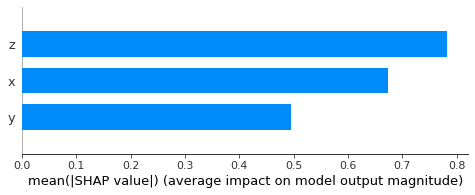

In [ ]:
shap.summary_plot(shap_values_XGB_test, X_test, plot_type="bar")


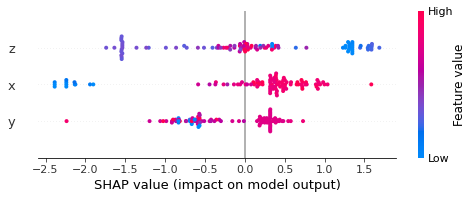

In [ ]:
shap.summary_plot(shap_values_XGB_test, X_test)

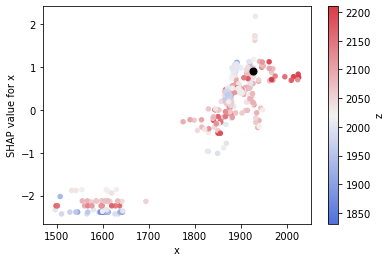

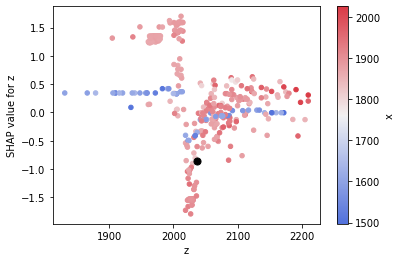

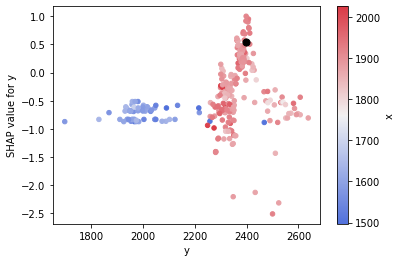

In [ ]:
import seaborn as sns

# inputs = column of interest as string, column for coloring as string, df of our data, SHAP df, 
#      x position of the black dot, y position of the black dot
def dep_plt(col, color_by, base_actual_df, base_shap_df, overlay_x, overlay_y):
  cmap=sns.diverging_palette(260, 10, sep=1, as_cmap=True) #seaborn palette
  f, ax = plt.subplots() 
  points = ax.scatter(base_actual_df[col], base_shap_df[col], c=base_actual_df[color_by], s=20, cmap=cmap)
  f.colorbar(points).set_label(color_by)
  ax.scatter(overlay_x, overlay_y, color='black', s=50) 
  plt.xlabel(col) 
  plt.ylabel("SHAP value for " + col) 
  plt.show()
 
# get list of model inputs in order of SHAP importance
imp_cols = df_shap_XGB_train.abs().mean().sort_values(ascending=False).index.tolist()
 
# loop through this list to show top 3 dependency plots
for i in range(0, len(imp_cols)):
    #plot the top var and color by the 2nd var 
  if i == 0 : 
    dep_plt(imp_cols[i],  
    imp_cols[i+1],  
    X_train,  
    df_shap_XGB_train, 
    X_test.iloc[j,:][imp_cols[i]], 
    df_shap_XGB_test.iloc[j,:][imp_cols[i]]) 
#plot the 2nd and 3rd vars and color by the top var
  if (i >0) and (i <= 3):  
    dep_plt(imp_cols[i],  
    imp_cols[0], X_train, 
    df_shap_XGB_train,
    X_test.iloc[j,:][imp_cols[i]], 
    df_shap_XGB_test.iloc[j,:][imp_cols[i]])

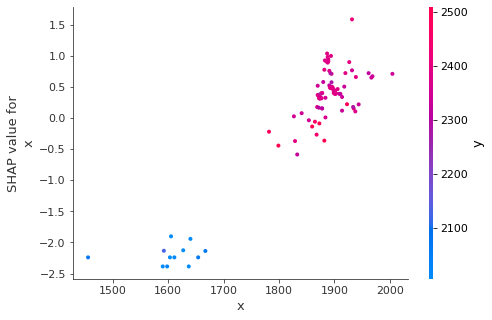

In [ ]:
shp_plt = shap.dependence_plot("x", shap_values_XGB_test, X_test)

#**2. SCIKIT LEARN - GradientBoostingRegressor**

In [ ]:
sk_xgb = sklearn.ensemble.GradientBoostingRegressor()
sk_xgb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

#GRADIENT BOOST REGRESSOR - ACCURACY SCORE

In [ ]:
print("ACCURACY SCORE\n")
print(sk_xgb.score(X_train,y_train))


ACCURACY SCORE

0.9325934385682154


In [ ]:
# Tree on Scikit GBT
t0 = time.time()
explainerSKGBT = shap.TreeExplainer(sk_xgb)
shap_values_SKGBT_test = explainerSKGBT.shap_values(X_test)
shap_values_SKGBT_train = explainerSKGBT.shap_values(X_train)
t1 = time.time()
timeit=t1-t0
print("TIME to interpret\n\n",timeit, "seconds")

TIME to interpret

 0.03831815719604492 seconds


In [ ]:
df_shap_SKGBT_test = pd.DataFrame(shap_values_SKGBT_test, columns=X_test.columns.values)
df_shap_SKGBT_train = pd.DataFrame(shap_values_SKGBT_train, columns=X_train.columns.values)

#**GRADIENTBOOST REGRESSOR - LOCAL INTERPRETABILITY**

In [ ]:
# j will be the record we explain
j = 0
# initialize js for SHAP
shap.initjs()
shap.force_plot(explainerSKGBT.expected_value, shap_values_SKGBT_test[j], X_test.iloc[[j]])

In [ ]:
shap.initjs()
shap.force_plot(explainerSKGBT.expected_value, shap_values_SKGBT_test, X_test)


#**GRADIENTBOOST REGRESSOR - GLOBAL INTERPRETABILITY**

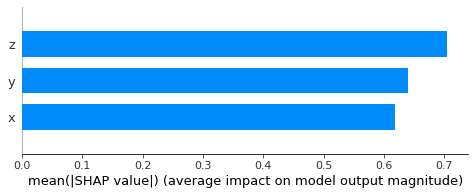

In [ ]:
shap.summary_plot(shap_values_SKGBT_test, X_test, plot_type="bar")

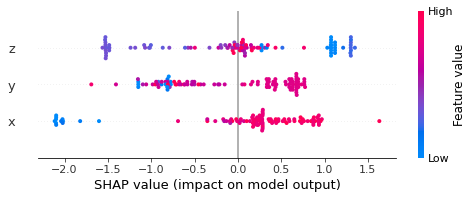

In [ ]:
shap.summary_plot(shap_values_SKGBT_test, X_test)

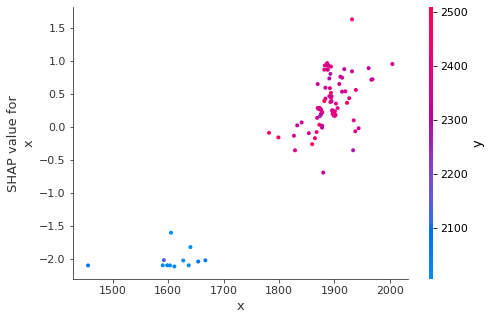

In [ ]:
shp_plt = shap.dependence_plot("x", shap_values_SKGBT_test, X_test)

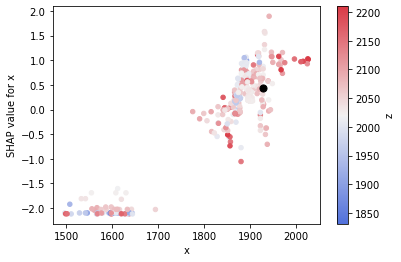

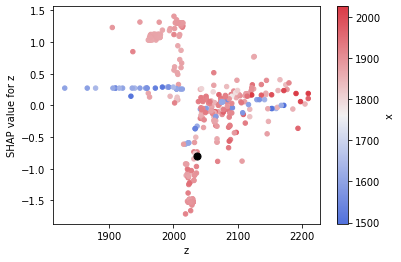

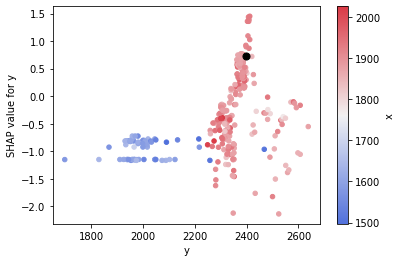

In [ ]:
import seaborn as sns

# inputs = column of interest as string, column for coloring as string, df of our data, SHAP df, 
#      x position of the black dot, y position of the black dot
def dep_plt(col, color_by, base_actual_df, base_shap_df, overlay_x, overlay_y):
  cmap=sns.diverging_palette(260, 10, sep=1, as_cmap=True) #seaborn palette
  f, ax = plt.subplots() 
  points = ax.scatter(base_actual_df[col], base_shap_df[col], c=base_actual_df[color_by], s=20, cmap=cmap)
  f.colorbar(points).set_label(color_by)
  ax.scatter(overlay_x, overlay_y, color='black', s=50) 
  plt.xlabel(col) 
  plt.ylabel("SHAP value for " + col) 
  plt.show()
 
# get list of model inputs in order of SHAP importance
imp_cols = df_shap_SKGBT_train.abs().mean().sort_values(ascending=False).index.tolist()
 
# loop through this list to show top 3 dependency plots
for i in range(0, len(imp_cols)):
    #plot the top var and color by the 2nd var 
  if i == 0 : 
    dep_plt(imp_cols[i],  
    imp_cols[i+1],  
    X_train,  
    df_shap_SKGBT_train, 
    X_test.iloc[j,:][imp_cols[i]], 
    df_shap_SKGBT_test.iloc[j,:][imp_cols[i]]) 
#plot the 2nd and 3rd vars and color by the top var
  if (i >0) and (i <= 3):  
    dep_plt(imp_cols[i],  
    imp_cols[0], X_train, 
    df_shap_SKGBT_train,
    X_test.iloc[j,:][imp_cols[i]], 
    df_shap_SKGBT_test.iloc[j,:][imp_cols[i]])

#**3. RANDOM FOREST**

In [ ]:
import sklearn.ensemble #for building models

rf = sklearn.ensemble.RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

#RF - ACCURACY SCORE

In [ ]:
print("ACCURACY SCORE\n")
print(rf.score(X_train,y_train))

ACCURACY SCORE

0.9655166617997004


In [ ]:
t0 = time.time()

explainerRF = shap.TreeExplainer(rf)
shap_values_RF_test = explainerRF.shap_values(X_test)
shap_values_RF_train = explainerRF.shap_values(X_train)
t1 = time.time()
timeit=t1-t0
print("TIME to interpret\n\n",timeit, "seconds")

categorical_features = np.argwhere(np.array([len(set(X_train.values[:,x]))
for x in range(X_train.values.shape[1])]) <= 10).flatten()

TIME to interpret

 0.4118530750274658 seconds


#**RF - LOCAL INTERPRETABILITY**

In [ ]:
j = 0
# initialize js for SHAP
shap.initjs()

shap.force_plot(explainerRF.expected_value, shap_values_RF_test[j], X_test.iloc[[j]])

In [ ]:
shap.initjs()
shap.force_plot(explainerRF.expected_value, shap_values_RF_test, X_test)


#**RF - GLOBAL INTERPRETABILITY**

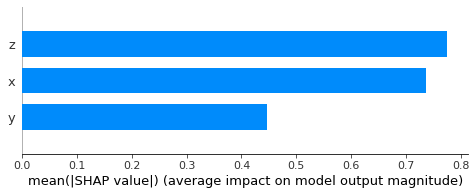

In [ ]:
shap.summary_plot(shap_values_RF_test, X_test, plot_type="bar")


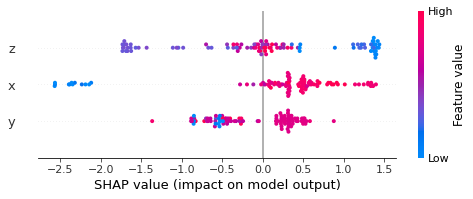

In [ ]:
shap.summary_plot(shap_values_RF_test, X_test)

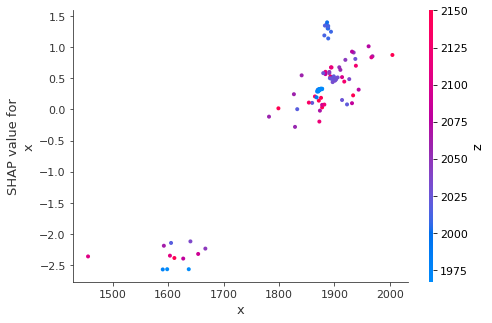

In [ ]:
shp_plt = shap.dependence_plot("x", shap_values_RF_test, X_test)


#**kERNEL EXPLAINERS**

#**1. KNN - Regressor**

In [ ]:
knn = sklearn.neighbors.KNeighborsRegressor()
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [ ]:
predicted3 = knn.predict(X_test)

#KNN - ACCURACY SCORE

In [ ]:
print("ACCURACY SCORE\n")
print(knn.score(X_train,y_train))


ACCURACY SCORE

0.8204149140410938


In [ ]:
X_train_summary = shap.kmeans(X_train, 10)

t0 = time.time()
explainerKNN = shap.KernelExplainer(knn.predict, X_train_summary)
shap_values_KNN_test = explainerKNN.shap_values(X_test)
shap_values_KNN_train = explainerKNN.shap_values(X_train)
t1 = time.time()
timeit=t1-t0
timeit
print("TIME to interpret\n\n",timeit,"seconds")


TIME to interpret

 2.9870541095733643 seconds


In [ ]:
df_shap_KNN_test = pd.DataFrame(shap_values_KNN_test, columns=X_test.columns.values)
df_shap_KNN_train = pd.DataFrame(shap_values_KNN_train, columns=X_train.columns.values)

#**KNN - LOCAL INTERPRETABILITY**

In [ ]:
j = 0
# initialize js for SHAP
shap.initjs()

shap.force_plot(explainerKNN.expected_value, shap_values_KNN_test[j], X_test.iloc[[j]])

In [ ]:
shap.initjs()

shap.force_plot(explainerKNN.expected_value, shap_values_KNN_test, X_test)


# **KNN - GLOBAL INTERPRETABILITY**

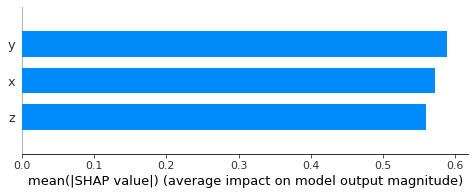

In [ ]:
shap.summary_plot(shap_values_KNN_test, X_test, plot_type="bar")

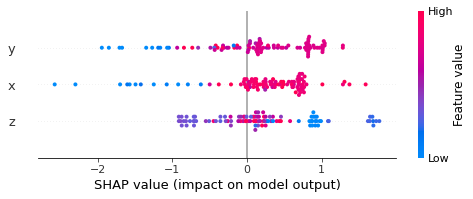

In [ ]:
shap.summary_plot(shap_values_KNN_test, X_test)

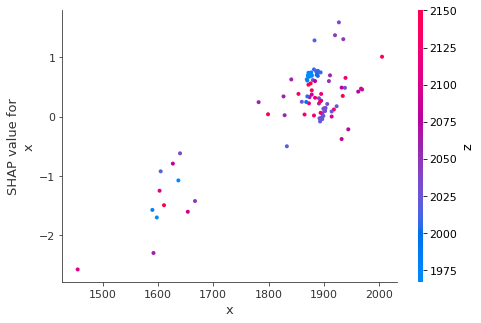

In [ ]:
shp_plt = shap.dependence_plot("x", shap_values_KNN_test, X_test)

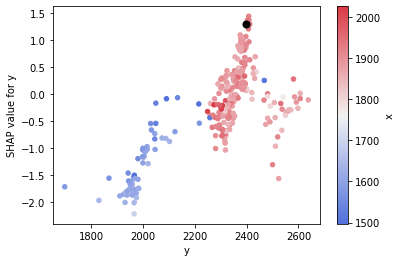

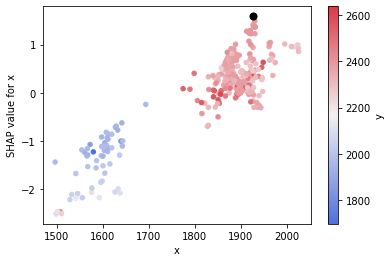

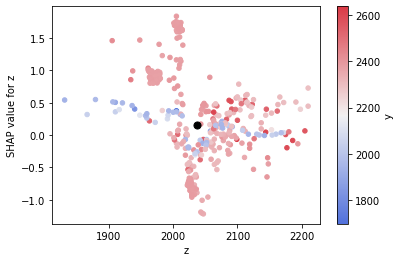

In [ ]:
import seaborn as sns

# inputs = column of interest as string, column for coloring as string, df of our data, SHAP df, 
#      x position of the black dot, y position of the black dot
def dep_plt(col, color_by, base_actual_df, base_shap_df, overlay_x, overlay_y):
  cmap=sns.diverging_palette(260, 10, sep=1, as_cmap=True) #seaborn palette
  f, ax = plt.subplots() 
  points = ax.scatter(base_actual_df[col], base_shap_df[col], c=base_actual_df[color_by], s=20, cmap=cmap)
  f.colorbar(points).set_label(color_by)
  ax.scatter(overlay_x, overlay_y, color='black', s=50) 
  plt.xlabel(col) 
  plt.ylabel("SHAP value for " + col) 
  plt.show()
 
# get list of model inputs in order of SHAP importance
imp_cols = df_shap_KNN_train.abs().mean().sort_values(ascending=False).index.tolist()
 
# loop through this list to show top 3 dependency plots
for i in range(0, len(imp_cols)):
    #plot the top var and color by the 2nd var 
  if i == 0 : 
    dep_plt(imp_cols[i],  
    imp_cols[i+1],  
    X_train,  
    df_shap_KNN_train, 
    X_test.iloc[j,:][imp_cols[i]], 
    df_shap_KNN_test.iloc[j,:][imp_cols[i]]) 
#plot the 2nd and 3rd vars and color by the top var
  if (i >0) and (i <= 3):  
    dep_plt(imp_cols[i],  
    imp_cols[0], X_train, 
    df_shap_KNN_train,
    X_test.iloc[j,:][imp_cols[i]], 
    df_shap_KNN_test.iloc[j,:][imp_cols[i]])

#**2. GradientBoostingClassifier**

In [ ]:
from sklearn import ensemble
n_estimators = 500
gbm = ensemble.GradientBoostingClassifier(
            n_estimators=n_estimators,
            random_state=0)
gbm.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
predicted4 = gbm.predict(X_test)

#GradientBoostingClassifier - ACCURACY SCORE

In [ ]:
print("ACCURACY SCORE\n")
print(metrics.accuracy_score(y_test, predicted4))
print("\nCONFUSION MATRIX\n")
print(metrics.confusion_matrix(y_test, predicted4))
print("\nCLASSIFICATION REPORT\n")
print(metrics.classification_report(y_test, predicted4))

ACCURACY SCORE

0.72

CONFUSION MATRIX

[[12  0  0  0  0  0  0]
 [ 0  6  0  4  1  0  0]
 [ 0  0 16  0  0  0  0]
 [ 0  6  0  4  4  0  1]
 [ 0  5  0  5  6  0  2]
 [ 0  0  0  0  0 16  0]
 [ 0  0  0  0  0  0 12]]

CLASSIFICATION REPORT

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       0.35      0.55      0.43        11
           3       1.00      1.00      1.00        16
           4       0.31      0.27      0.29        15
           5       0.55      0.33      0.41        18
           6       1.00      1.00      1.00        16
           7       0.80      1.00      0.89        12

    accuracy                           0.72       100
   macro avg       0.72      0.74      0.72       100
weighted avg       0.72      0.72      0.71       100



In [ ]:
t0 = time.time()

gbm_explainer = shap.KernelExplainer(gbm.predict, X_train)
gbm_shap_values = gbm_explainer.shap_values(X_train)

t1 = time.time()
timeit=t1-t0
timeit
print("TIME to interpret\n\n",timeit,"seconds")


Using 396 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.



TIME to interpret

 65.29732012748718 seconds


#**GRADIENT BOOST CLASSIFIER - LOCAL INTERPRETABILITY**

In [ ]:
j = 0
# initialize js for SHAP
shap.initjs()

shap.force_plot(gbm_explainer.expected_value,gbm_shap_values[0,:], X_test.iloc[0,:]) #, link="logit")

In [ ]:
shap.initjs()
shap.force_plot(gbm_explainer.expected_value, gbm_shap_values[0:100], X_test)


#**GRADIENT BOOST CLASSIFIER - GLOBAL INTERPRETABILITY**



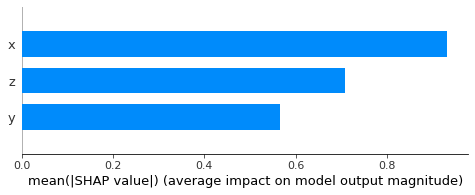

In [ ]:
shap.summary_plot(gbm_shap_values, X_test,plot_type="bar")

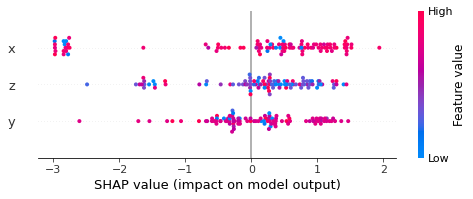

In [ ]:

shap.summary_plot(gbm_shap_values[0:100], X_test)

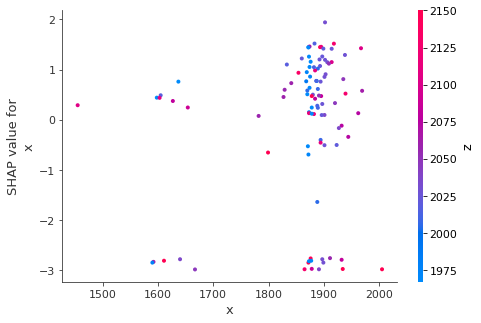

In [ ]:
shap.dependence_plot("x", gbm_shap_values[0:100], X_test)

#**3. SVM**

In [ ]:
from sklearn import svm
svm = svm.SVC(gamma='scale', decision_function_shape='ovo')
svm.fit(X_train, y_train)  


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
predicted5 = svm.predict(X_test)

#SVM - ACCURACY SCORE

In [ ]:
print("ACCURACY SCORE\n")
print(metrics.accuracy_score(y_test, predicted5))
print("\nCONFUSION MATRIX\n")
print(metrics.confusion_matrix(y_test, predicted5))
print("\nCLASSIFICATION REPORT\n")
print(metrics.classification_report(y_test, predicted5))

ACCURACY SCORE

0.5

CONFUSION MATRIX

[[12  0  0  0  0  0  0]
 [ 0  3  0  1  2  2  3]
 [ 0  0  0  0  0  0 16]
 [ 0  4  0  6  2  0  3]
 [ 0  3  0  9  5  0  1]
 [ 0  0  0  0  0 16  0]
 [ 0  0  4  0  0  0  8]]

CLASSIFICATION REPORT

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       0.30      0.27      0.29        11
           3       0.00      0.00      0.00        16
           4       0.38      0.40      0.39        15
           5       0.56      0.28      0.37        18
           6       0.89      1.00      0.94        16
           7       0.26      0.67      0.37        12

    accuracy                           0.50       100
   macro avg       0.48      0.52      0.48       100
weighted avg       0.48      0.50      0.47       100



In [ ]:
t0 = time.time()

svm_explainer = shap.KernelExplainer(svm.predict, X_test)
svm_shap_values = svm_explainer.shap_values(X_test)

t1 = time.time()
timeit=t1-t0
timeit
print("TIME to interpret\n\n",timeit,"seconds")




TIME to interpret

 3.711456060409546 seconds


#**SVM - LOCAL INTERPRETABILITY**

In [ ]:
shap.initjs()

shap.force_plot(svm_explainer.expected_value,svm_shap_values[0,:], X_test.iloc[0,:])

In [ ]:
shap.initjs()

shap.force_plot(svm_explainer.expected_value, svm_shap_values, X_test)

#**SVM - GLOBAL INTERPRETABILITY**

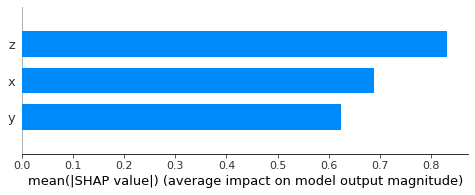

In [ ]:
shap.summary_plot(svm_shap_values, X_test, plot_type="bar")

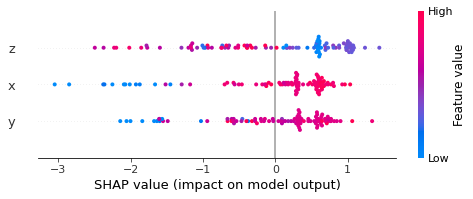

In [ ]:
shap.summary_plot(svm_shap_values, X_test)

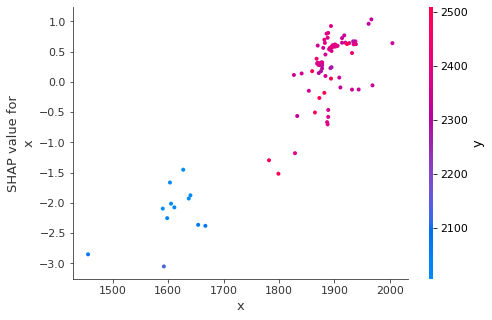

In [ ]:
shap.dependence_plot("x", svm_shap_values, X_test)

#**4. DECISION TREE CLASSIFIER**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
predicted = model.predict(X_test)

#DECISION TREE CLASSIFIER - ACCURACY SCORE

In [ ]:
print("ACCURACY SCORE\n")
print(metrics.accuracy_score(y_test, predicted))
print("\nCONFUSION MATRIX\n")
print(metrics.confusion_matrix(y_test, predicted))
print("\nCLASSIFICATION REPORT\n")
print(metrics.classification_report(y_test, predicted))

ACCURACY SCORE

0.74

CONFUSION MATRIX

[[12  0  0  0  0  0  0]
 [ 0  6  0  4  1  0  0]
 [ 0  0 16  0  0  0  0]
 [ 0  3  0  5  7  0  0]
 [ 0  3  0  7  8  0  0]
 [ 0  0  0  0  0 16  0]
 [ 0  0  0  0  1  0 11]]

CLASSIFICATION REPORT

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       0.50      0.55      0.52        11
           3       1.00      1.00      1.00        16
           4       0.31      0.33      0.32        15
           5       0.47      0.44      0.46        18
           6       1.00      1.00      1.00        16
           7       1.00      0.92      0.96        12

    accuracy                           0.74       100
   macro avg       0.75      0.75      0.75       100
weighted avg       0.75      0.74      0.74       100



In [ ]:
t0 = time.time()

dt_explainer = shap.KernelExplainer(model.predict, X_test)
dt_shap_values = dt_explainer.shap_values(X_test)

t1 = time.time()
timeit=t1-t0
timeit
print("TIME to interpret\n\n",timeit,"seconds")


TIME to interpret

 2.6791725158691406 seconds


#**DECISION TREE CLASSIFIER - LOCAL INTERPRETABILITY**

In [ ]:
shap.initjs()
shap.force_plot(dt_explainer.expected_value,dt_shap_values[0,:], X_test.iloc[0,:]) 


In [ ]:
shap.initjs()
shap.force_plot(dt_explainer.expected_value, dt_shap_values, X_test)

#**DECISION TREE CLASSIFIER - GLOBAL INTERPRETABILITY**

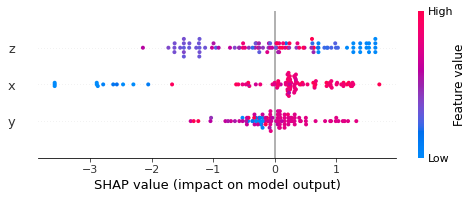

In [ ]:
shap.summary_plot(dt_shap_values, X_test)

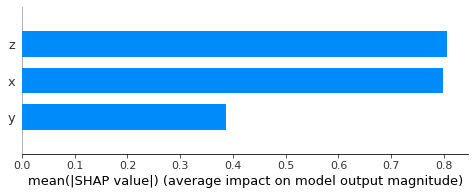

In [ ]:
shap.summary_plot(dt_shap_values , X_test, plot_type="bar")


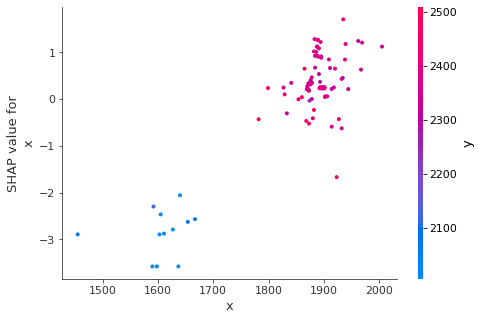

In [ ]:
shap.dependence_plot("x", dt_shap_values, X_test)

# **GRAPHS AGAINST ACCRACY AND TIME FOR BLACK BOX MODELS**

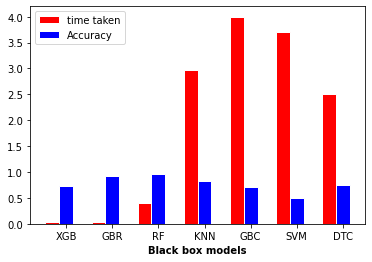

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

barWidth = 0.3

bars1 = [0.036,0.037,0.4,2.98,4,3.7,2.5] 
bars2 = [0.73,0.93,0.96,0.82,0.72,0.5,0.74]

 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

 
# Make the plot
plt.bar(r1, bars1, color='red', width=barWidth, edgecolor='white', label='time taken')
plt.bar(r2, bars2, color='blue', width=barWidth, edgecolor='white', label='Accuracy')
 
# Add xticks on the middle of the group bars
plt.xlabel('Black box models', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['XGB', 'GBR', 'RF', 'KNN', 'GBC','SVM','DTC'])
 
# Create legend & Show graphic
plt.legend()
plt.show()
